Original Size: 7593.75 KB
Compressed Size (theory): 1265.67 KB
Theoretical Compression Rate: 6.00x
File Size Original (PNG): 2395.20 KB
File Size Compressed (PNG): 364.85 KB
File Compression Rate: 6.56x


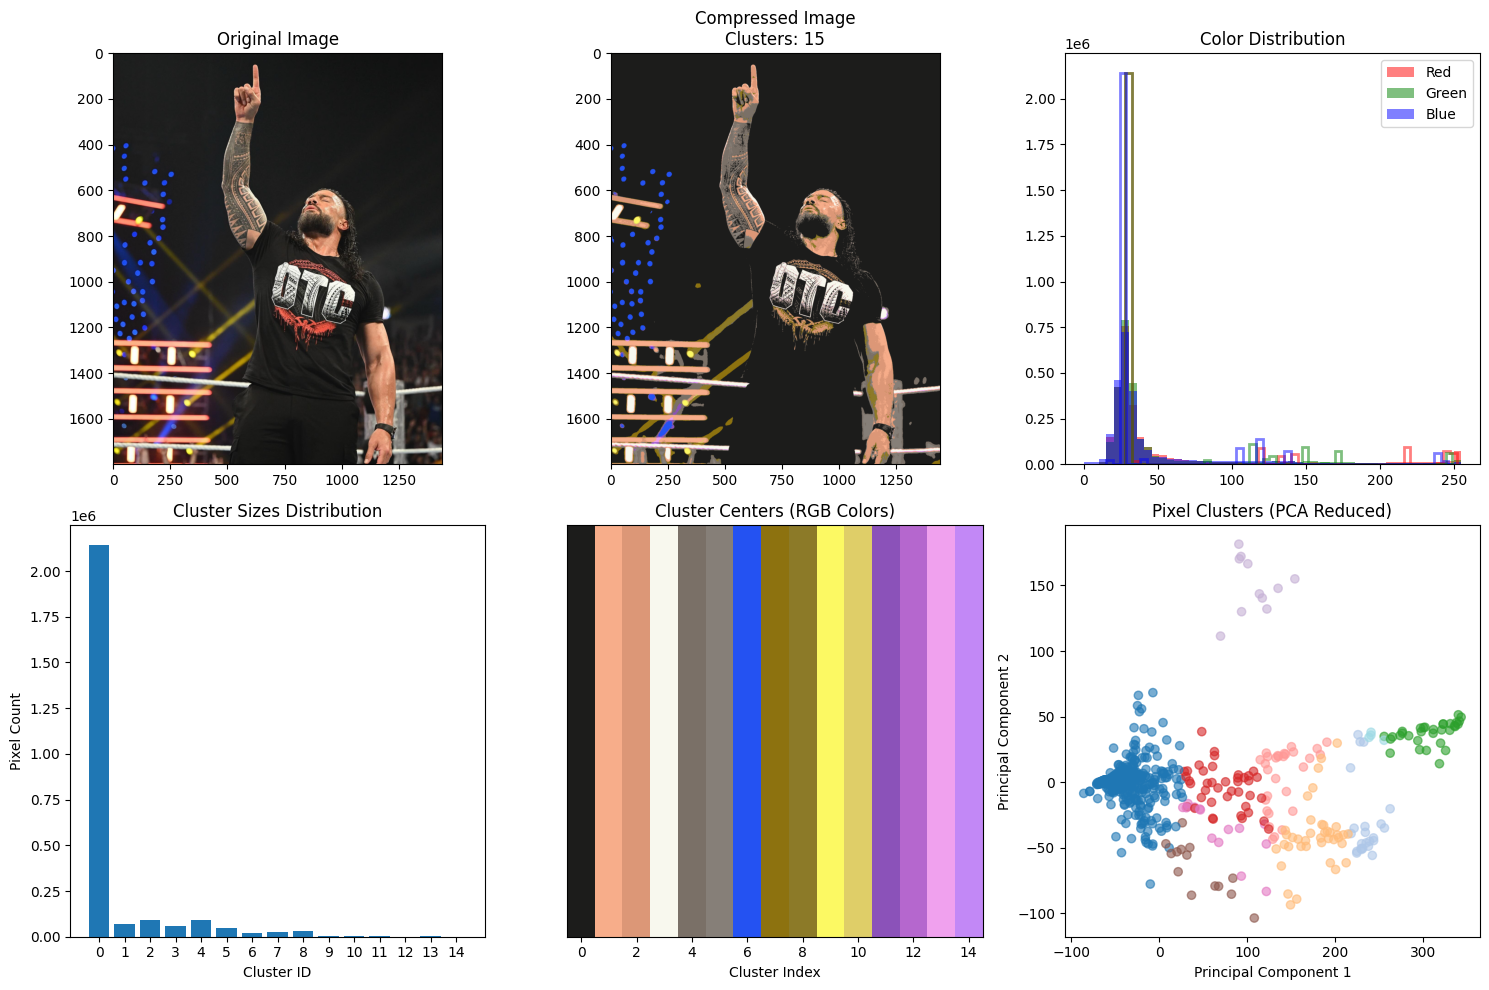

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA

def load_and_preprocess(image_path):
    # Load image and convert to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def apply_mean_shift(image, quantile=0.1):
    # Reshape image to 2D array of pixels
    h, w, _ = image.shape
    X = image.reshape(-1, 3)

    # Estimate bandwidth
    bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=1000)

    # Apply Mean Shift
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)

    return ms, h, w

def create_compressed_image(ms, h, w):
    # Get labels and cluster centers
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    # Create compressed image
    compressed = cluster_centers[labels].reshape(h, w, 3).astype(np.uint8)

    return compressed, labels, cluster_centers

def calculate_metrics(original, compressed, labels, cluster_centers):
    # Original image size
    original_size = original.nbytes

    # Calculate compressed size (approximation)
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)
    bits_per_pixel = np.ceil(np.log2(num_clusters)) if num_clusters > 1 else 1
    compressed_size_bits = (len(labels) * bits_per_pixel) + (num_clusters * 3 * 8)
    compressed_size_bytes = compressed_size_bits / 8

    # Actual size if saved as PNG
    _, encoded_original = cv2.imencode('.png', cv2.cvtColor(original, cv2.COLOR_RGB2BGR))
    _, encoded_compressed = cv2.imencode('.png', cv2.cvtColor(compressed, cv2.COLOR_RGB2BGR))

    return {
        'original_size': original_size,
        'compressed_size': compressed_size_bytes,
        'compression_rate': original_size / compressed_size_bytes,
        'num_clusters': num_clusters,
        'file_size_original': len(encoded_original),
        'file_size_compressed': len(encoded_compressed),
        'file_compression_rate': len(encoded_original) / len(encoded_compressed)
    }

def plot_results(original, compressed, labels, cluster_centers, metrics):
    plt.figure(figsize=(15, 10))

    # Plot original and compressed images
    plt.subplot(231)
    plt.imshow(original)
    plt.title('Original Image')

    plt.subplot(232)
    plt.imshow(compressed)
    plt.title(f'Compressed Image\nClusters: {metrics["num_clusters"]}')

    # Plot color distributions
    plt.subplot(233)
    for i, color in enumerate(['r', 'g', 'b']):
        plt.hist(original[..., i].ravel(), bins=50, alpha=0.5, color=color, label=['Red', 'Green', 'Blue'][i])
        plt.hist(compressed[..., i].ravel(), bins=50, alpha=0.5, color=color, histtype='step', linewidth=2)
    plt.title('Color Distribution')
    plt.legend()

    # Plot cluster sizes
    plt.subplot(234)
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(range(len(unique)), counts, tick_label=unique)
    plt.title('Cluster Sizes Distribution')
    plt.xlabel('Cluster ID')
    plt.ylabel('Pixel Count')

    # Plot cluster centers as color swatches
    plt.subplot(235)
    plt.imshow([cluster_centers.astype(np.uint8)], aspect='auto')
    plt.title('Cluster Centers (RGB Colors)')
    plt.yticks([])
    plt.xlabel('Cluster Index')

    # Plot PCA-reduced pixel clusters
    plt.subplot(236)
    sample_indices = np.random.choice(len(labels), 1000)
    sampled_pixels = original.reshape(-1, 3)[sample_indices]
    sampled_labels = labels[sample_indices]

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(sampled_pixels)

    plt.scatter(reduced[:, 0], reduced[:, 1], c=sampled_labels, cmap='tab20', alpha=0.6)
    plt.title('Pixel Clusters (PCA Reduced)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.tight_layout()
    plt.show()

def main(image_path):
    # Load and process image
    original = load_and_preprocess(image_path)

    # Apply Mean Shift clustering
    ms, h, w = apply_mean_shift(original)

    # Create compressed image
    compressed, labels, centers = create_compressed_image(ms, h, w)

    # Calculate metrics
    metrics = calculate_metrics(original, compressed, labels, centers)

    # Print metrics
    print(f"Original Size: {metrics['original_size']/1024:.2f} KB")
    print(f"Compressed Size (theory): {metrics['compressed_size']/1024:.2f} KB")
    print(f"Theoretical Compression Rate: {metrics['compression_rate']:.2f}x")
    print(f"File Size Original (PNG): {metrics['file_size_original']/1024:.2f} KB")
    print(f"File Size Compressed (PNG): {metrics['file_size_compressed']/1024:.2f} KB")
    print(f"File Compression Rate: {metrics['file_compression_rate']:.2f}x")

    # Plot results
    plot_results(original, compressed, labels, centers, metrics)

if __name__ == "__main__":
    image_path = "/content/RomanReigns.jpg"  # Replace with your image path
    main(image_path)